# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from helper_functions import *
from statsmodels.discrete.discrete_model import Logit

curr_dir = mkdirifnotexists(os.path.join('microbiome_pattern'))

# Load data

In [401]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')
pnp_data = pnp_data[pnp_data.IsGenotek == 0]
pnp_data = pnp_data[pnp_data.Nextera == 'True']
acs_data['ACS sample'] = 1
pnp_data['ACS sample'] = 0

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [402]:
acs_199 = acs_data['k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii|fSGB__222|gSGB__534|sSGB__714'].dropna().index
acs_data.loc[acs_199]['Admission Diagnosis'].value_counts()
# acs_data['Admis']
acs_data.loc[acs_199]['Admission Diagnosis: UA'].sum()

30

In [403]:
data = pd.concat((acs_data, pnp_data), axis=0, sort=False).filter(regex='k__|Age|gender|ACS sample').copy()
print (data.shape)

mb_data = remove_rare_elements(data.filter(regex='k__').dropna(how='all').T, rare_def=0.05, null=False).T.apply(np.log10)
print (mb_data.shape)

data = pd.concat((data.filter(regex='Age|gender|ACS sample'), mb_data), axis=1).dropna(how='any')
print (data.shape)
data['const'] = 1

(542, 2976)
removing 0.742 of elements.
(539, 768)
(534, 771)


# MMC no HPN+Dys

In [405]:
matched_samples = pd.read_csv(os.path.join(paper_dir, 'Matching', 'PNP1-ACS_matching', 'PNP1-ACS_microbiome_age+sex+bmi+DM+smoking_1:1.csv'), index_col=0)
matched_pnp_data = data.loc[matched_samples[matched_samples['ACS sample'] == 0].index]
matched_acs_data = data.loc[matched_samples[matched_samples['ACS sample'] == 1].index]
matched_data = data.loc[matched_samples.index].copy()

In [412]:
y = 'ACS sample'
# data['const'] = 1
covariates = ['Age', 'gender', 'const']
use_covariates = True
cols = matched_data.filter(regex='k__').columns
# samples = mmc_pnp.tolist() + mmc_acs.tolist()

# pvals = pd.DataFrame(np.nan, index=cols, columns=['unmatched Logit', 'matched Logit'])
logs = pd.DataFrame(index=cols, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
logit_results = pd.DataFrame(index=cols, columns=['Logit ' + c for c in columns])

for col in tqdm_notebook(cols):
    if covariates:
        try:
            log = Logit(matched_data.loc[:, y].astype(float), 
                                    matched_data.loc[:, [col] + covariates], missing='drop').fit(disp=0)
            logit_results.loc[col, 'Logit coef'] = log.params.loc[col]#np.exp(log.params.loc[col])
            logit_results.loc[col, 'Logit pval'] = log.pvalues.loc[col]
            logit_results.loc[col, 'Logit 0.025'], logit_results.loc[col, 'Logit 0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[col, 'Logit log'] = log
        except:
            pass
    else:
        pass
logit_results['Logit qval'] = fdr_correction(logit_results['Logit pval'])[1]
logit_results_mmc_no_hpn = logit_results.dropna()
logit_results_mmc_no_hpn['directional pval'] = logit_results_mmc_no_hpn.apply(lambda x: np.log10(x['Logit pval']) * -np.sign(x['Logit coef']), axis=1)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimizat

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [418]:
logit_results_mmc_no_hpn.sort_values('Logit pval').head(20)

,Logit coef,Logit pval,Logit 0.025,Logit 0.975,Logit log,Logit qval,directional pval
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_hadrus|fSGB__1413|gSGB__3421|sSGB__4540,-1.57471,6.98013e-06,0.1042,0.411487,<statsmodels.discrete.discrete_model.BinaryRes...,0.00536074,-5.156136
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__unknown|fSGB__1445|gSGB__3572|sSGB__4780,-2.43312,1.67305e-05,0.0289851,0.265731,<statsmodels.discrete.discrete_model.BinaryRes...,0.00538473,-4.776491
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas|s__Butyricimonas_sp_An62|fSGB__588|gSGB__1330|sSGB__1785,2.55732,2.10341e-05,3.97081,41.9162,<statsmodels.discrete.discrete_model.BinaryRes...,0.00538473,4.677076
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas|s__Butyricimonas_synergistica|fSGB__588|gSGB__1330|sSGB__1786,1.7053,7.01183e-05,2.37418,12.7553,<statsmodels.discrete.discrete_model.BinaryRes...,0.0134627,4.154169
k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_83|fSGB__3056|gSGB__9632|sSGB__15089,1.68394,0.000125657,2.27797,12.7382,<statsmodels.discrete.discrete_model.BinaryRes...,0.0193009,3.900813
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_sp|fSGB__1449|gSGB__3604|sSGB__4868,-1.1335,0.00015408,0.178969,0.579001,<statsmodels.discrete.discrete_model.BinaryRes...,0.0197222,-3.812255
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Odoribacter|s__Odoribacter_splanchnicus|fSGB__589|gSGB__1333|sSGB__1790,1.49276,0.000183522,2.03524,9.72699,<statsmodels.discrete.discrete_model.BinaryRes...,0.020135,3.736311
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__unknown|fSGB__3058|gSGB__9741|sSGB__15340,-1.23805,0.000411349,0.145886,0.576275,<statsmodels.discrete.discrete_model.BinaryRes...,0.0363856,-3.385789
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli|fSGB__2483|gSGB__6985|sSGB__10068,0.829665,0.000426394,1.44501,3.63719,<statsmodels.discrete.discrete_model.BinaryRes...,0.0363856,3.370189
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_sp|fSGB__1449|gSGB__3596|sSGB__4828,-0.945511,0.000518217,0.227777,0.662566,<statsmodels.discrete.discrete_model.BinaryRes...,0.0397991,-3.285488


In [417]:
logit_results_mmc_no_hpn.dropna().shape
(logit_results_mmc_no_hpn['Logit qval']<0.1).sum()

20

In [414]:
logit_results_mmc_no_hpn.to_csv(os.path.join(curr_dir, 'logit_results_mmc_no_hpn+dys.csv'))

## metacardis replication

In [419]:
metacardis_dir = os.path.join('MetaCardis')
metacardis_X_path = os.path.join(metacardis_dir, 'dataframes', 'mb_diet_covariates_drugs_group.csv')
metacardis_metabolomics_path = os.path.join(metacardis_dir, 'metabolomics', 'robust_zs_metabolomics/proc_metabolomics_clipped.csv')
metacardis_X = pd.read_csv(metacardis_X_path, index_col=0)
metacardis_metadata_path = os.path.join(metacardis_dir, 'metabolomics', 'metadata', 'hub.metadata_reduced.samples.v10.r')
metacardis_X = metacardis_X.merge(pd.read_csv(metacardis_metadata_path, sep='\t', index_col=0)[['PATGROUPFINAL_C']], on='SampleID', how='left')
metacardis_X_age_bmi = metacardis_X[['AGE', 'BMI_C', 'Group']].copy()
metacardis_metabolomics = pd.read_csv(metacardis_metabolomics_path, index_col=0)
print (set([s.split('___')[0] for s in metacardis_metabolomics.columns]))
metacardis_serum_metabolomics = metacardis_metabolomics.loc[:, ['urine' not in s.split('___')[0] for s in metacardis_metabolomics.columns]].dropna()
# metacardis_serum_metabolomics = metacardis_metabolomics.filter(regex='hub.lipo.samples.v3.r')
full_index = list(set(metacardis_serum_metabolomics.index).intersection(set(metacardis_X_age_bmi.index)))
metacardis_serum_metabolomics, metacardis_X_age_bmi = metacardis_serum_metabolomics.loc[full_index].astype(float), metacardis_X_age_bmi.loc[full_index]
metacardis_serum_metabolomics.index.names = ['SampleID']
metacardis_X_age_bmi.Group.value_counts()

{'hub.serum_absolute.v1.samples.r', 'hub.serum_tmao.v1.samples.r', 'hub.lipo.samples.v3.r', 'hub.urine_annotated.samples.v2.r'}


IHD372     269
HC275      225
MMC269     188
UMCC222    159
Name: Group, dtype: int64

In [421]:
# for k in logit_results.sort_values('matched Logit pval').head(20).index:
for k in logit_results_mmc_no_hpn.sort_values('Logit pval').head(20).index:
    kk = k.split('|')[-1]
    for gr in ['HC275', 'MMC269', 'UMCC222']:
        t, p = directed_mannwhitneyu(metacardis_X[metacardis_X['PATGROUPFINAL_C']=='4'].filter(regex=kk).iloc[:, 0].dropna(), 
                      metacardis_X[metacardis_X['Group']==gr].filter(regex=kk).iloc[:, 0].dropna())
#         t, p = directed_mannwhitneyu(metacardis_X[metacardis_X['Group']=='IHD372'].filter(regex=kk).iloc[:, 0].dropna(), 
#                       metacardis_X[metacardis_X['Group']==gr].filter(regex=kk).iloc[:, 0].dropna())
        print (kk, gr, t, p)
    print ()

sSGB__4540 HC275 9961.0 0.26628472852839213
sSGB__4540 MMC269 -7507.0 0.11132113259738002
sSGB__4540 UMCC222 -7902.0 0.4260863584054201

sSGB__4780 HC275 8922.0 0.01986435742496288
sSGB__4780 MMC269 -7396.0 0.05520148101630925
sSGB__4780 UMCC222 -7100.0 0.044623225806767454

sSGB__1785 HC275 10116.0 0.31299011977442015
sSGB__1785 MMC269 8196.0 0.43569024458149996
sSGB__1785 UMCC222 -7919.0 0.4240077592569216

sSGB__1786 HC275 10332.0 0.42992161931523626
sSGB__1786 MMC269 7685.0 0.14327088328337778
sSGB__1786 UMCC222 7718.0 0.2874246628518259

sSGB__15089 HC275 -10143.0 0.3470775097655681
sSGB__15089 MMC269 -7948.0 0.2980154326409209
sSGB__15089 UMCC222 -7480.0 0.1901126360104562

sSGB__4868 HC275 9721.5 0.17080884570328891
sSGB__4868 MMC269 8195.0 0.44304267164283107
sSGB__4868 UMCC222 7445.5 0.17127752270779517

sSGB__1790 HC275 10029.5 0.2958257605052904
sSGB__1790 MMC269 7152.5 0.03815182021419614
sSGB__1790 UMCC222 -7998.0 0.48745435563942247

sSGB__15340 HC275 10204.0 0.3763005692

(-7902.0, 0.4260863584054201)

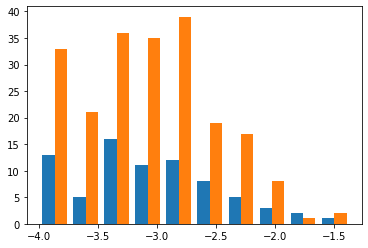

In [353]:
k = 'sSGB__4540'
plt.hist([metacardis_X[metacardis_X['PATGROUPFINAL_C']=='4'].filter(regex=k).apply(np.log10).iloc[:, 0], 
          metacardis_X[metacardis_X['Group']=='UMCC222'].filter(regex=k).apply(np.log10).iloc[:, 0]])
directed_mannwhitneyu(metacardis_X[metacardis_X['PATGROUPFINAL_C']=='4'].filter(regex=k).iloc[:, 0].dropna(), 
          metacardis_X[metacardis_X['Group']=='UMCC222'].filter(regex=k).iloc[:, 0].dropna())
# metacardis_X_age_bmi
# metacardis_X